In [ ]:
!sudo apt update && sudo apt install --assume-yes p7zip-full
!7z e "instacart-market-basket-analysis.7z.001"


In [4]:
%pip install -U tensorflow-addons

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install numpy pandas matplotlib seaborn scikit-learn


Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [7]:

order_products__train = pd.read_csv("order_products__train.csv")
order_products__prior = pd.read_csv("order_products__prior.csv")
orders=pd.read_csv("orders.csv")
products=pd.read_csv("products.csv")
departments=pd.read_csv("departments.csv")
aisles=pd.read_csv("aisles.csv")

In [8]:
print("The order_products_train size is : ", order_products__train.shape)
print("The order_products_prior size is : ", order_products__prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [9]:
order_products_all = pd.concat([order_products__train, order_products__prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [10]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
order_id,0,0.0
product_id,0,0.0
add_to_cart_order,0,0.0
reordered,0,0.0


In [11]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate([('Total_products','count')]).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


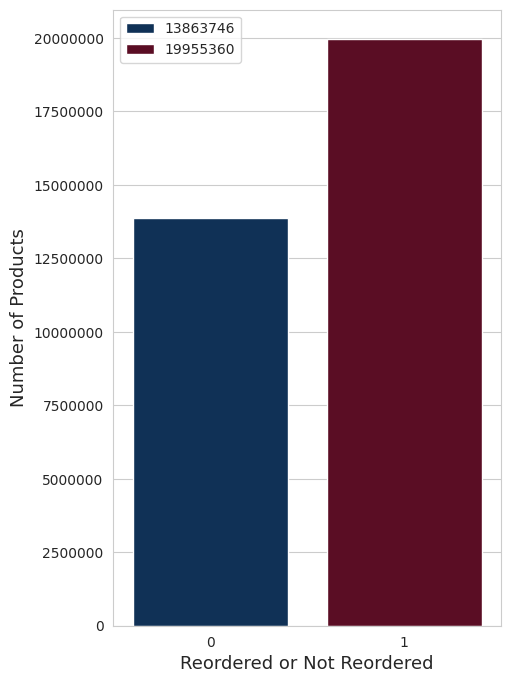

In [12]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(x=grouped.index, y=grouped.values,
            palette='RdBu_r', hue=grouped.values)
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

In [13]:
orders_df = pd.read_csv( "orders.csv", usecols=["order_id","user_id","order_number"])

In [14]:
prior_df = order_products__prior

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,6,40462,1,0,22352,4
1,6,15873,2,0,22352,4
2,6,41897,3,0,22352,4
3,8,23423,1,1,3107,5
4,13,17330,1,0,45082,2


In [15]:
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


In [16]:
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


In [17]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


In [18]:
train_df = pd.read_csv( "order_products__train.csv", usecols=["order_id"])
train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


In [19]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


In [20]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

,order_id,user_id,order_number
0,38,42756,6
1,96,17227,7
2,98,56463,41
3,226,51011,4
4,762,41751,5


In [21]:
test_df = pd.read_csv( "sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

,order_id,user_id,order_number
0,17,36855,5
1,34,35220,20
2,257,35581,9
3,386,55492,8
4,418,33565,12


In [22]:
print(train_df.shape, test_df.shape)

(40096, 3) (23004, 3)


In [23]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,order_number,product_id,reordered_count,reordered_sum,reordered_latest
0,38,42756,6,1940,2,1,NaN
1,38,42756,6,2124,1,0,0.0
2,38,42756,6,2314,1,0,NaN
3,38,42756,6,4428,1,0,NaN
4,38,42756,6,8012,4,3,1.0


In [24]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

,order_id,user_id,order_number,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,5,1283,1,0,NaN
1,17,36855,5,6291,1,0,NaN
2,17,36855,5,7035,1,0,NaN
3,17,36855,5,11494,1,0,NaN
4,17,36855,5,13107,3,2,1.0


In [25]:
products_df = pd.read_csv( "products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


In [26]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,order_number,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,38,42756,6,1940,2,1,NaN,84,16
1,7916,30825,4,1940,3,2,1.0,84,16
2,9934,48962,10,1940,4,3,NaN,84,16
3,10812,37929,23,1940,1,0,NaN,84,16
4,12847,37602,5,1940,1,0,0.0,84,16


In [27]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

,order_id,user_id,order_number,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,5,1283,1,0,NaN,100,21
1,657743,16994,10,1283,1,0,NaN,100,21
2,2829393,19117,53,1283,1,0,NaN,100,21
3,17,36855,5,6291,1,0,NaN,121,14
4,25782,31066,5,6291,1,0,NaN,121,14


In [28]:
train_y_df = pd.read_csv( "order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(2588813, 10)


In [29]:
%pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [31]:
X=train_df.drop('reordered',axis=1)

In [32]:
X.head()

,order_id,user_id,order_number,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,38,42756,6,1940,2,1,NaN,84,16
1,7916,30825,4,1940,3,2,1.0,84,16
2,9934,48962,10,1940,4,3,NaN,84,16
3,10812,37929,23,1940,1,0,NaN,84,16
4,12847,37602,5,1940,1,0,0.0,84,16


In [33]:
Y =train_df['reordered']

In [34]:
Y.head()

0    0.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: reordered, dtype: float64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=7)

In [36]:
model = XGBClassifier()

In [37]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [38]:
y_pred = model.predict(X_test)

In [39]:
predictions = [round(value) for value in y_pred]

In [40]:
accuracy = accuracy_score(y_test, predictions)

In [41]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.65%


In [42]:
# target variable for train set #
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

(2588813, 7) (1478030, 7)


In [43]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

In [44]:
# run the xgboost model #
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df[out_df["Pred"].astype('int')==1]

/workspace/.pyenv_mirror/user/current/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:53:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


In [45]:
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

In [46]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv( "sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("xgb_starter_3450.csv", index=False)

In [47]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

,order_id,user_id,order_number,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
78949,319276,8706,46,39275,1,0,0.0,123,4
2032816,2051794,17962,13,3773,1,0,0.0,72,13
966202,1913936,28178,11,43693,2,1,0.0,84,16
2278365,717984,15409,26,40407,1,0,0.0,130,14
1624461,2572910,31788,16,3027,2,1,0.0,80,11
...,...,...,...,...,...,...,...,...,...
2155915,2819270,60624,28,895,10,9,0.0,120,16
1253370,1565581,26916,10,22849,1,0,0.0,123,4
2270445,161826,47509,22,20247,19,18,0.0,86,16
2129303,1530246,28270,14,22767,4,3,0.0,37,1


In [48]:
%pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [49]:
import lightgbm as lgb

In [50]:
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

In [51]:
assert False


AssertionError: 

In [ ]:
model= lgb.LGBMClassifier()

In [ ]:
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 25522, number of negative: 233359
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 258881, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.098586 -> initscore=-2.213037
[LightGBM] [Info] Start training from score -2.213037


LGBMClassifier()

In [ ]:
pred=model.predict(X_test)

In [ ]:
#accuracy score of Light GBM
print(accuracy_score(pred, y_test))

0.9072432156818311


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
model = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.9002640420407119

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier



In [ ]:
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9065367572959211


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LogisticRegression
clf=(LogisticRegression(C=0.02))
clf.fit(X_train, y_train)
#predictions
pred=clf.predict(X_test)
#accuracy score of Logistic Regression Model
print(accuracy_score(pred, y_test))

0.9019679544295713


AssertionError: 

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training a SVM classifier using SVC class
svm = SVC(kernel= 'linear', random_state=1, C=0.1, verbose=True)
svm.fit(X_train_std, y_train)

# Mode performance

y_pred = svm.predict(X_test_std)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))


[LibSVM]...........................

In [ ]:
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8446594149528828


In [ ]:
estimator = []
estimator.append(('LR',
                  LogisticRegression(solver ='lbfgs',
                                     multi_class ='multinomial',
                                     max_iter = 200)))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('DTC', DecisionTreeClassifier()))


# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

# using accuracy_score metric to predict accuracy
score = accuracy_score(y_test, y_pred)
print("Hard Voting Score % d" % score)

# Voting Classifier with soft voting
vot_soft = VotingClassifier(estimators = estimator, voting ='soft')
vot_soft.fit(X_train, y_train)
y_pred = vot_soft.predict(X_test)

# using accuracy_score
score = accuracy_score(y_test, y_pred)
print("Soft Voting Score % d" % score)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)
clfrf.fit(X_train, y_train)
predrf=clfrf.predict(X_test)
accuracy_score(predrf, y_test)

/workspace/.pyenv_mirror/user/current/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


0.906840628825219

In [ ]:
model1 = tree.DecisionTreeClassifier()
model2 = XGBClassifier()
model3= LogisticRegression()

model1.fit(X_train,y_train)
model2.fit(X_train,y_train)
model3.fit(X_train,y_train)

pred1=model1.predict_proba(X_test)
pred2=model2.predict_proba(X_test)
pred3=model3.predict_proba(X_test)

finalpred=(pred1+pred2+pred3)/3
print(finalpred)

[[0.55822154 0.44177845]
 [0.87174362 0.12825637]
 [0.79188146 0.20811854]
 ...
 [0.52199947 0.47800053]
 [0.77831937 0.22168063]
 [0.48083704 0.51916297]]


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
model.fit(X_train, y_train)
model.score(X_test,y_test)

0.9019679544295713

In [ ]:
%pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 16.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 106.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from catboost import CatBoostClassifier
model=CatBoostClassifier()
params = {'learning_rate': 0.1, 'depth': 6,\
          'l2_leaf_reg': 3, 'iterations': 100}

# Initialize the CatBoostClassifier object
# with the defined hyperparameters and fit it on the training set
model = CatBoostClassifier(**params)
model.fit(X_train, y_train)
# Predict the target variable on the validation
# set and evaluate the performance
y_pred = model.predict(X_test)
accuracy = (y_pred == np.array(y_test)).mean()
print("Validation Accuracy:", accuracy)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
params_knn = {"n_neighbors": np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gs = GridSearchCV(knn, params_knn, cv=5)
#fit model to training data
knn_gs.fit(X_train, y_train)
#save best model
knn_best = knn_gs.best_estimator_
#check best n_neigbors value
print(knn_gs.best_params_)

{'n_neighbors': 20}


In [ ]:
from sklearn.ensemble import VotingClassifier
#create a dictionary of our models
estimator = []
estimator.append(('LR',
                  LogisticRegression(solver ='lbfgs',
                                     multi_class ='multinomial',
                                     max_iter = 200)))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('DTC', DecisionTreeClassifier()))
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimator, voting="hard")

In [ ]:
#fit model to training data
ensemble.fit(X_train, y_train)
#test our model on the test data
ensemble.score(X_test, y_test)

0.9026593714213004

In [ ]:
!pip install feats

In [ ]:
!pip install singlecelldata

In [ ]:
!pip install constants

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.8/153.8 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of constants to determine which version is compatible with other requirements. This could take a while.
  Preparing metadata (setup.py) ... done
  Created wheel for constants: filename=constants-0.6.0-py3-none-any.whl size=5456 sha256=0f404c8ef813fcd25f2a2daa3a9f20773d97114eb3994ce786bde9a90d518a19
  Stored in directory: /root/.cache/pip/wheels/5b/96/3c/386c2342a8a1bdd317f2f250bd076c13938c6f598c4a40ec14
Successfully built constants


In [ ]:
#defining the model
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
input_layer=Input(shape=(len(X_train.columns)))
d1=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d1')(input_layer)
d2=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d2')(d1)
d3=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d3')(d2)
d4=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d4')(d3)
d5=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d5')(d4)
d6=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d6')(d5)
output_layer=Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='output')(d6)
model_7layer = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_7layer.summary()
model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 9)]               0         
                                                                 
 d1 (Dense)                  (None, 100)               1000      
                                                                 
 d2 (Dense)                  (None, 100)               10100     
                                                                 
 d3 (Dense)                  (None, 100)               10100     
                                                                 
 d4 (Dense)                  (None, 100)               10100     
                                                                 
 d5 (Dense)                  (None, 100)               10100     
                                                                 
 d6 (Dense)                  (None, 100)               1010

TypeError: ignored

In [ ]:
from tqdm import tqdm
tqdm.pandas()
def mean_f1score(df):
  '''This function imitates the mean f1 score that is used in the competition. Calculates the mean of f1 scores for each order'''
  df['tp']=df.reordered_new*df.pred_reordered
  df['tn']=(1-df.reordered_new)*(1-df.pred_reordered)
  df['fp']=(1-df.reordered_new)*(df.pred_reordered)
  df['fn']=(df.reordered_new)*(1-df.pred_reordered)
  df1=df.groupby(['user_id']).agg({'tp':sum,'tn':sum,'fp':sum,'fn':sum})
  df1['precision']=df1['tp']/(df1['tp']+df1['fp'])
  df1.precision.fillna(0,inplace=True)
  df1['recall']=df1['tp']/(df1['tp']+df1['fn'])
  df1.recall.fillna(0,inplace=True)
  df1['f1']=2*df1['precision']*df1['recall']/(df1['precision']+df1['recall'])
  df1.f1.fillna(0,inplace=True)
  return sum(df1.f1)/len(df1)

In [ ]:
#defining the model
def best_mean_f1_score_tf(pred_train_y,pred_cv_y):
  ''' function to calculate best mean f1 score for train data and cv data after trying all thresholds'''
  p_range=[0.1*p for p in range(0,11,1)]
  train_mean_f1scores=[]
  cv_mean_f1scores=[]
  for p in p_range:
    train_df['pred_reordered']=(pred_train_y>=p)
    test_df['pred_reordered']=(pred_cv_y>=p)
    train_mean_f1scores.append(mean_f1score(train_df))
    cv_mean_f1scores.append(mean_f1score(test_df))
  print('threshold','train f1 score',p_range[np.argmax(train_mean_f1scores)],max(train_mean_f1scores))
  print('threshold','cv f1 score',p_range[np.argmax(cv_mean_f1scores)],max(cv_mean_f1scores))
  return max(cv_mean_f1scores)

import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
input_layer=Input(shape=(len(X_train.columns)))
d1=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d1')(input_layer)
d2=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d2')(d1)
d3=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d3')(d2)
d4=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d4')(d3)
d5=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d5')(d4)
d6=Dense(units=100,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='d6')(d5)
output_layer=Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='output')(d6)
model_7layer = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model_7layer.summary()



Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 9)]               0         
                                                                 
 d1 (Dense)                  (None, 100)               1000      
                                                                 
 d2 (Dense)                  (None, 100)               10100     
                                                                 
 d3 (Dense)                  (None, 100)               10100     
                                                                 
 d4 (Dense)                  (None, 100)               10100     
                                                                 
 d5 (Dense)                  (None, 100)               10100     
                                                                 
 d6 (Dense)                  (None, 100)               1010

In [ ]:
def best_mean_f1_score_tf(pred_train_y,pred_cv_y):
  ''' function to calculate best mean f1 score for train data and cv data after trying all thresholds'''
  p_range=[0.1*p for p in range(0,11,1)]
  train_mean_f1scores=[]
  cv_mean_f1scores=[]
  for p in p_range:
    train_df['pred_reordered']=(pred_train_y>=p)
    test_df['pred_reordered']=(pred_cv_y>=p)
    train_mean_f1scores.append(mean_f1score(train_df))
    cv_mean_f1scores.append(mean_f1score(test_df))
  print('threshold','train f1 score',p_range[np.argmax(train_mean_f1scores)],max(train_mean_f1scores))
  print('threshold','cv f1 score',p_range[np.argmax(cv_mean_f1scores)],max(cv_mean_f1scores))
  return max(cv_mean_f1scores)

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier

n_estimators = [1, 3, 5, 10]
learning_rates = [0.1, 0.5, 1, 1.5, 2, 2.5]
cv_f1_scores = []
train_f1_scores = []

for n in n_estimators:
    for l in learning_rates:
        ada_clf = AdaBoostClassifier(random_state=42, n_estimators=n, learning_rate=l)
        ada_clf.fit(X_train, y_train)
        pred_train_y = ada_clf.predict(X_train)
        pred_cv_y = ada_clf.predict(X_test)
        print('n_estimator', n, 'learning_rate', l)
        train_f1 = f1_score(y_train, pred_train_y)
        cv_f1 = f1_score(y_test, pred_cv_y)
        print('Train F1 Score:', train_f1)
        print('CV F1 Score:', cv_f1)
        cv_f1_scores.append(cv_f1)
        train_f1_scores.append(train_f1)


n_estimator 1 learning_rate 0.1
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 1 learning_rate 0.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 1 learning_rate 1
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 1 learning_rate 1.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 1 learning_rate 2
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 1 learning_rate 2.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 3 learning_rate 0.1
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 3 learning_rate 0.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 3 learning_rate 1
Train F1 Score: 0.0346099412445855
CV F1 Score: 0.03727881807249614
n_estimator 3 learning_rate 1.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 3 learning_rate 2
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 3 learning_rate 2.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 5 learning_rate 0.1
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator 5 learning_rate 0.5
Train F1 Score: 0.0
CV F1 Score: 0.0
n_estimator

In [ ]:
#performing hyper-parameter tuning of Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rf_clf=RandomForestClassifier()
n_estimators=[5,10,20]
class_weight=[{0:1,1:1},{0:1,1:5},{0:1,1:10}]
max_depth=[5,10,15]
cv_f1_scores=[]
train_f1_scores=[]
for n in n_estimators:
  for w in class_weight:
    for d in max_depth:
        rf_clf=RandomForestClassifier(n_estimators=n,max_depth=d,class_weight=w,random_state=42,n_jobs=8)
        rf_clf.fit(X_train,y_train)
        pred_train_y=rf_clf.predict(X_train)
        pred_test_y=rf_clf.predict(X_test)
        train_f1_score=f1_score(y_train,pred_train_y)
        cv_f1_score=f1_score(y_test,pred_test_y)
        print('n_estimators',n,'class_weight',w,'max_depth',d,'train_f1score',train_f1_score,'cv f1score',cv_f1_score)
        train_f1_scores.append(train_f1_score)
        cv_f1_scores.append(cv_f1_score)

n_estimators 5 class_weight {0: 1, 1: 1} max_depth 5 train_f1score 0.18529327840047258 cv f1score 0.18217910478148888
n_estimators 5 class_weight {0: 1, 1: 1} max_depth 10 train_f1score 0.24161163237729097 cv f1score 0.23063956755081083
n_estimators 5 class_weight {0: 1, 1: 1} max_depth 15 train_f1score 0.31480770387368096 cv f1score 0.23826844747560863
n_estimators 5 class_weight {0: 1, 1: 5} max_depth 5 train_f1score 0.3996839646406815 cv f1score 0.39871618608799053
n_estimators 5 class_weight {0: 1, 1: 5} max_depth 10 train_f1score 0.41249581999434093 cv f1score 0.40597567048445615
n_estimators 5 class_weight {0: 1, 1: 5} max_depth 15 train_f1score 0.45550741106102416 cv f1score 0.3992581866219546
n_estimators 5 class_weight {0: 1, 1: 10} max_depth 5 train_f1score 0.34282826020323953 cv f1score 0.3420735517939425
n_estimators 5 class_weight {0: 1, 1: 10} max_depth 10 train_f1score 0.3440431102773753 cv f1score 0.3416069289917206
n_estimators 5 class_weight {0: 1, 1: 10} max_depth 15

In [ ]:
#defining the custom callback for model7
from sklearn.metrics import f1_score
class custom_callback(tf.keras.callbacks.Callback):
  def __init__(self):
    super()
    self.max_score=0.30


  def on_epoch_end(self, epoch, logs={}):
        #on every epoch end we are storing the validation accuracy in the history dict
        #checking if we have any nan values across our weights
        is_nan_values=[]
        for i in self.model.get_weights():
          is_nan_values.append(np.isnan(i).any())

        #stopping the model training if any weights have nan
        if np.array(is_nan_values).any():
          self.model.stop_training = True




#compiling the model
model_7layer.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005),loss='binary_crossentropy',metrics=['accuracy'],run_eagerly=True)

#training the model
model_7layer.fit(X_train,y_train.astype(np.float32),batch_size=10000,epochs=30,callbacks=[custom_callback()])

Epoch 1/30
26/26 [==============================] - 3s 102ms/step - loss: 5187.5742 - accuracy: 0.6749
Epoch 2/30
26/26 [==============================] - 3s 101ms/step - loss: 1217.4799 - accuracy: 0.7221
Epoch 3/30
26/26 [==============================] - 2s 85ms/step - loss: 439.6977 - accuracy: 0.6993
Epoch 4/30
26/26 [==============================] - 2s 85ms/step - loss: 305.1689 - accuracy: 0.7070
Epoch 5/30
26/26 [==============================] - 2s 86ms/step - loss: 423.5933 - accuracy: 0.7286
Epoch 6/30
26/26 [==============================] - 2s 86ms/step - loss: 277.7897 - accuracy: 0.7215
Epoch 7/30
26/26 [==============================] - 3s 116ms/step - loss: 267.9132 - accuracy: 0.6780
Epoch 8/30
26/26 [==============================] - 2s 86ms/step - loss: 169.6255 - accuracy: 0.7343
Epoch 9/30
26/26 [==============================] - 3s 99ms/step - loss: 209.9240 - accuracy: 0.7241
Epoch 10/30
26/26 [==============================] - 3s 108ms/step - loss: 59.0579 - a

In [ ]:
#creating cnn model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Concatenate,Conv1D,MaxPool1D,Dropout
input_layer=Input(shape=(len(X_train.columns),1))
conv1a=Conv1D(128, 3, activation='relu')(input_layer)
conv1b=Conv1D(128, 5, activation='relu')(input_layer)
conv1c=Conv1D(128, 7, activation='relu')(input_layer)
concat1=Concatenate(axis=1)([conv1a, conv1b, conv1c])
max1=MaxPool1D(pool_size=2,strides=1, padding='valid')(concat1)
conv2a=Conv1D(64, 3, activation='relu')(max1)
conv2b=Conv1D(64, 5, activation='relu')(max1)
conv2c=Conv1D(64, 7, activation='relu')(max1)
concat2=Concatenate(axis=1)([conv2a, conv2b, conv2c])
max2=MaxPool1D(pool_size=2,strides=1, padding='valid')(concat2)
conv3a=Conv1D(16, 3, activation='relu')(max2)
flat=Flatten()(conv3a)
drp=Dropout(.2)(flat)
d1=Dense(units=50,activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),name='FC1')(drp)
output_layer=Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(d1)
conv_model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
conv_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 9, 1)]               0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 7, 128)               512       ['input_5[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 5, 128)               768       ['input_5[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 3, 128)               1024      ['input_5[0][0]']             
                                                                                            

In [ ]:
#defining the custom callback for conv model
from sklearn.metrics import f1_score
class custom_callback(tf.keras.callbacks.Callback):
  def __init__(self):
    super()
    self.max_score=0.30


  def on_epoch_end(self, epoch, logs={}):
        #on every epoch end we are storing the validation accuracy in the history dict
        #checking if we have any nan values across our weights
        is_nan_values=[]
        for i in self.model.get_weights():
          is_nan_values.append(np.isnan(i).any())

        #stopping the model training if any weights have nan
        if np.array(is_nan_values).any():
          self.model.stop_training = True

        #print f1 score for every epoch


#compiling the model
conv_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'],run_eagerly=True)

#training the model
conv_model.fit(X_train,y_train.astype(np.float32),batch_size=1000,epochs=10,callbacks=[custom_callback()])

Epoch 1/10
259/259 [==============================] - 63s 242ms/step - loss: 0.4623 - accuracy: 0.8259
Epoch 2/10
259/259 [==============================] - 66s 253ms/step - loss: 0.8004 - accuracy: 0.8259
Epoch 3/10
259/259 [==============================] - 64s 246ms/step - loss: 0.5213 - accuracy: 0.8259
Epoch 4/10
259/259 [==============================] - 67s 260ms/step - loss: 0.4890 - accuracy: 0.8259
Epoch 5/10
259/259 [==============================] - 62s 239ms/step - loss: 0.4623 - accuracy: 0.8259
Epoch 6/10
259/259 [==============================] - 62s 241ms/step - loss: 0.4623 - accuracy: 0.8259
Epoch 7/10
259/259 [==============================] - 62s 241ms/step - loss: 0.4628 - accuracy: 0.8259
Epoch 8/10
259/259 [==============================] - 62s 241ms/step - loss: 0.4713 - accuracy: 0.8259
Epoch 9/10
259/259 [==============================] - 73s 281ms/step - loss: 0.4744 - accuracy: 0.8259
Epoch 10/10
259/259 [==============================] - 63s 242ms/step - l

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (258732, 9)
y_train shape: (258732,)


In [ ]:
import numpy as np
import gc
import tensorflow as tf
from sklearn.metrics import f1_score

class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super()
        self.max_score = 0.30

    def on_epoch_end(self, epoch, logs={}):
        is_nan_values = []
        for i in self.model.get_weights():
            is_nan_values.append(np.isnan(i).any())

        if np.array(is_nan_values).any():
            self.model.stop_training = True

        y_preds_train = self.model.predict(X_train, batch_size=10000)
        y_preds_cv = self.model.predict(X_test, batch_size=10000)
        gc.collect()

        cv_mean_f1 = f1_score(y_train, (y_preds_train > 0.1).astype(int))

        if cv_mean_f1 > self.max_score:
            self.max_score = cv_mean_f1
            self.model.save('nn_models/layer7_model_f1' + str(cv_mean_f1))
        gc.collect()

# Assuming you have X_train, X_cv, and y_train properly defined.

# Compile the model
model_7layer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Training the model
model_7layer.fit(X_train, y_train.astype(np.float32), batch_size=10000, epochs=30, callbacks=[CustomCallback()])


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Embedding
from tensorflow.keras.models import Model


# Concatenate the CNN and LSTM outputs
combined = tf.keras.layers.concatenate([flat, lstm])

# Add a fully connected layer for the final output
output = Dense(num_classes, activation='softmax')(combined)

# Create the model
model = Model(inputs=[image_input, text_input], outputs=output)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with your data
model.fit([image_data, text_data], labels, epochs=epochs, batch_size=batch_size)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import random


"""
Neural Networks model : Bidirection LSTM
"""


class BiLSTM(nn.Module):

    def __init__(self, args):
        super(BiLSTM, self).__init__()
        self.args = args
        self.hidden_dim = args.lstm_hidden_dim
        self.num_layers = args.lstm_num_layers
        V = args.embed_num
        D = args.embed_dim
        C = args.class_num
        # self.embed = nn.Embedding(V, D, max_norm=config.max_norm)
        self.embed = nn.Embedding(V, D, padding_idx=args.paddingId)
        # pretrained  embedding
        if args.word_Embedding:
            self.embed.weight.data.copy_(args.pretrained_weight)
        self.bilstm = nn.LSTM(D, self.hidden_dim // 2, num_layers=1, dropout=args.dropout, bidirectional=True, bias=False)
        print(self.bilstm)

        self.hidden2label1 = nn.Linear(self.hidden_dim, self.hidden_dim // 2)
        self.hidden2label2 = nn.Linear(self.hidden_dim // 2, C)
        # self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        embed = self.embed(x)
        x = embed.view(len(x), embed.size(1), -1)
        bilstm_out, _ = self.bilstm(x)

        bilstm_out = torch.transpose(bilstm_out, 0, 1)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        bilstm_out = F.tanh(bilstm_out)
        bilstm_out = F.max_pool1d(bilstm_out, bilstm_out.size(2)).squeeze(2)
        y = self.hidden2label1(bilstm_out)
        y = self.hidden2label2(y)
        logit = y
        return logit

In [52]:
%pip install keras tensorflow


Defaulting to user installation because normal site-packages is not writeable


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

# generate and prepare the dataset


def get_data():
	trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
	return trainX, trainy, testX, testy

# define and fit the model


def get_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(100, input_shape=(9,), activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy',
	              optimizer='adam', metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=10, verbose=1)
	return model


# generate data
trainX, trainy, testX, testy = get_data()
# fit model
model = get_model(trainX, trainy)


# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=1)
# predict crisp classes for test set

yhat_classes = np.argmax(model.predict(x_test), axis=1)
# yhat_classes = model.predict_classes(testX, verbose=1)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_classes)
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(testy, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(testy, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(testy, yhat_classes)
print(matrix)


   1/8091 [..............................] - ETA: 53:57 - loss: 232368.2188 - accuracy: 0.0938

72811/72811 [==============================] - 61s 834us/step


NameError: name 'x_test' is not defined